# **Project: Healthcare Suppliers Analysis and Prediction**
**Author:** Giovanni Capanna
---
### **Section 1: Business Understanding**
#### **Brief Description**
The healthcare system and access to care are complex topics. A key factor for patients is knowing whether a healthcare supplier "accepts assignment," which directly impacts costs and accessibility. This project aims to analyze a [public dataset from the Centers for Medicare & Medicaid Services (CMS)](https://data.cms.gov/provider-data/) to shed light on this ecosystem.
#### **Project Questions**
Through the analysis of this data, we will seek to answer three main questions:
1.  **Question 1:** In which states are most healthcare suppliers concentrated?
2.  **Question 2:** What is the proportion of suppliers who accept assignment compared to those who do not?
3.  **Question 3:** Is it possible to build a machine learning model to predict whether a new supplier will accept assignment based on its characteristics?


### **Section 2: Data Understanding**
#### **Access and Explore**
In this phase, we load the data and conduct a preliminary exploration to understand its structure, data types, and the presence of missing values.
**Initial Observations:**
*   The dataset contains 59,091 rows and 17 columns.
*   It includes numerical (`latitude`), boolean (`acceptsassignement`), and many `object` (text) type columns.
*   Columns such as `practiceaddress2`, `providertypelist`, and `supplieslist` have a significant number of missing values that will need to be handled.

In [100]:
# Import the necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Load the dataset
df = pd.read_csv('Medical-Equipment-Suppliers.csv')
# Explore the dataset
print("--- General information about DataFrame ---")
df.info()
print("\n--- First 5 rows of DataFrame ---")
display(df.head())

--- General information about DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59091 entries, 0 to 59090
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   provider_id             59091 non-null  int64  
 1   acceptsassignement      59091 non-null  bool   
 2   participationbegindate  59091 non-null  object 
 3   businessname            59091 non-null  object 
 4   practicename            59091 non-null  object 
 5   practiceaddress1        59091 non-null  object 
 6   practiceaddress2        13128 non-null  object 
 7   practicecity            59091 non-null  object 
 8   practicestate           59091 non-null  object 
 9   practicezip9code        59091 non-null  int64  
 10  telephonenumber         59091 non-null  int64  
 11  specialitieslist        58330 non-null  object 
 12  providertypelist        6937 non-null   object 
 13  supplieslist            59059 non-null  object 

,provider_id,acceptsassignement,participationbegindate,businessname,practicename,practiceaddress1,practiceaddress2,practicecity,practicestate,practicezip9code,telephonenumber,specialitieslist,providertypelist,supplieslist,latitude,longitude,is_contracted_for_cba
0,20335931,False,2025-03-12,CVS PHARMACY INC,CVS PHARMACY #17769,1708 DELL RANGE BLVD,NaN,CHEYENNE,WY,820094945,3078293118,Pharmacy,NaN,Immunosuppressive Drugs|Infusion Drugs|Nebuliz...,41.16037,-104.79940,False
1,20314913,False,2025-03-12,CVS PHARMACY INC,CVS PHARMACY #16322,7608 NE ZAC LENTZ PKWY,NaN,VICTORIA,TX,779041390,3615796716,Pharmacy,NaN,Immunosuppressive Drugs|Infusion Drugs|Nebuliz...,28.86565,-96.99893,False
2,20314925,False,2025-03-12,CVS PHARMACY INC,CVS PHARMACY # 17561,259 INTERSTATE 45 S,NaN,HUNTSVILLE,TX,773404903,9366493074,Pharmacy,NaN,Immunosuppressive Drugs|Infusion Drugs|Nebuliz...,30.70962,-95.56535,False
3,20314325,False,2025-03-12,CVS PHARMACY INC,CVS PHARMACY #17095,8223 STATE HIGHWAY 151,NaN,SAN ANTONIO,TX,782452104,2102470017,Pharmacy,NaN,Immunosuppressive Drugs|Infusion Drugs|Nebuliz...,29.43615,-98.65015,False
4,20314379,False,2025-03-12,CVS PHARMACY INC,CVS PHARMACY #16908,11311 BANDERA RD,NaN,SAN ANTONIO,TX,782506812,2106822533,Pharmacy,NaN,Immunosuppressive Drugs|Infusion Drugs|Nebuliz...,29.54832,-98.66206,False



--- Missing values analysis ---
                  Missing values  Percentage (%)
providertypelist           52154       88.260480
practiceaddress2           45963       77.783419
specialitieslist             761        1.287844
supplieslist                  32        0.054154


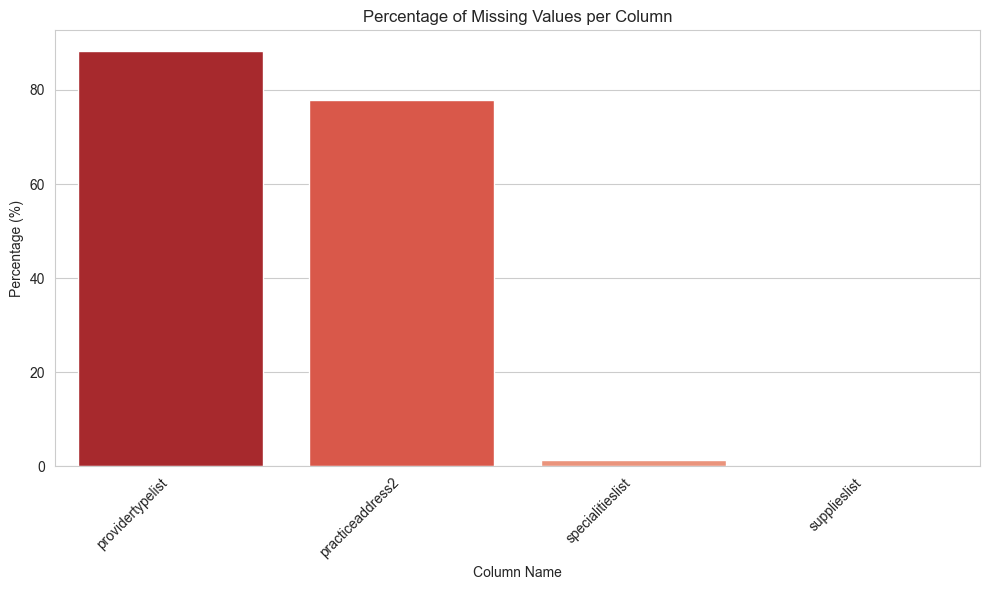

In [101]:
# calculate missing values percentage per column

missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
# create a DataFrame to summarize missing values
missing_info = pd.DataFrame({'Missing values': missing_values, 'Percentage (%)': missing_percentage})
missing_info = missing_info[missing_info['Missing values'] > 0].sort_values(by='Percentage (%)', ascending=False)
print("\n--- Missing values analysis ---")
print(missing_info)
# Grafical visualization of missing values
if not missing_info.empty:
    plt.figure(figsize=(10, 6))
    
    sns.barplot(
        x=missing_info.index, 
        y=missing_info['Percentage (%)'], 
        hue=missing_info.index,  
        palette='Reds_r', 
        legend=False             
    )
    # ---------------------
    plt.title('Percentage of Missing Values per Column')
    plt.ylabel('Percentage (%)')
    plt.xlabel('Column Name') 
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout() 
    plt.show()

**Observations on Missing Values:**
The analysis reveals important findings:
*   The `practiceaddress2` column has almost 100% missing values. It is clearly unusable.
*   `providertypelist` and `supplieslist` have a significant percentage of missing values (between 80% and 90%).
*   Other columns, such as `specialitieslist`, have a smaller but still relevant amount of missing data.
This assessment is the basis for the decisions we will make in the next section.


### **Section 3: Prepare Data**
#### **Clean**
In this section, we apply the cleaning decisions based on our assessment. We encapsulate the logic into a function to ensure the process is documented, consistent, and reusable.
#### **Justification for Handling Missing Data and Categorical Variables**
Before writing the code, it is crucial to justify our choices:
1.  **Handling Columns with Many Missing Values (`practiceaddress2`, `providertypelist`, `supplieslist`):**
    *   **Chosen Approach:** **Column Deletion.**
    *   **Justification:** These columns have an extremely high percentage of missing data (from 80% to 99%). Imputing (filling) these values would be problematic for several reasons:
        *   **Data Distortion:** Imputing 80% of the data with a single value (like the mode) or with more complex techniques would introduce a huge amount of artificial information, severely distorting the natural patterns present in the remaining 20% of the data. The model would learn more from the "invented" data than from the real data.
        *   **Lack of Reliable Signal:** With so little real data, it is impossible to determine a reliable imputation strategy. The risk of introducing a significant bias is too high.
    *   **Conclusion:** Given the scarcity of useful information, deleting these columns is the safest and most honest approach to preserve the integrity of the analysis and not base our model on largely artificial data. As explained in [this post on imputation](https://www.udacity.com/course/viewer#!/c-nd025/l-6195514392/m-6228389025), when the percentage of missing data is this high, deletion is often the most prudent choice.
2.  **Handling Categorical Variables (`practicestate`, `specialitieslist`, etc.):**
    *   **Chosen Approach:** **One-Hot Encoding.**
    *   **Justification:** Machine learning models like the `RandomForestClassifier` require numerical inputs. Categorical (text) variables must be converted. One-Hot Encoding is the appropriate choice in this case because:
        *   **No Ordinal Relationship:** Our categories (like states or medical specialties) have no inherent order (e.g., "Texas" is not "greater" or "lesser" than "California"). One-Hot Encoding creates a new binary (0/1) column for each category, treating them all as separate, independent entities, which respects the non-ordinal nature of the data.
        *   **Model Compatibility:** Tree-based models, such as Random Forest, work very well with this type of sparse binary feature, as they can identify patterns based on the presence or absence of a given category.
These decisions aim to create a clean and meaningful dataset, maximizing the real information and representing it in an optimal format for our predictive model.


In [102]:
def clean_and_prepare_data(df: pd.DataFrame) -> pd.DataFrame:
    """Cleans and prepares the DataFrame for modeling according to a defined logic.
    This function implements the cleaning decisions justified above:
    1. Removes columns with too many missing values or irrelevant data.
    2. Handles remaining missing values, if necessary.
    3. Applies one-hot encoding to categorical columns for modeling.
    Args:
        df (pd.DataFrame): The original DataFrame.
    Returns:
        pd.DataFrame: A clean and ready-to-model DataFrame.
    """
    print("Starting data cleaning and preparation...")
    
    # 1. Drop columns with too many missing values or irrelevant data
    # The columns 'practiceaddress2', 'providertypelist', and 'supplieslist' have too many missing values (>80%).
    # 'practiceaddress2' is almost entirely missing, so it is clearly unusable. 
    columns_to_drop = [
        'provider_id', 'practicename', 'businessname', 'practiceaddress1',
        'practiceaddress2', # Deleted due to almost 99% missing values
        'telephonenumber', 'participationbegindate', 'practicecity',
        'providertypelist', # Deleted due >80% missing values
        'supplieslist',     # Deleted due >80% missing values
        'practicezip9code'
    ]
    df_cleaned = df.drop(columns=columns_to_drop, errors='ignore')
    # 2. Handling remaining missing values
    # In this case, the 'specialitieslist' column has a few NaNs.
    # The simplest option is to drop these few rows, as their
    # impact on the overall dataset (59k rows) is negligible.
    df_cleaned.dropna(inplace=True)
    # 3. Application of One-Hot Encoding 
    categorical_cols = df_cleaned.select_dtypes(include=['object']).columns
    df_prepared = pd.get_dummies(df_cleaned, columns=categorical_cols)
    
    print(f"Data preparation finished for {df_prepared.shape[0]} row.")
    return df_prepared
# Application of the cleaning function
print("\n--- Cleaning and preparing the data ---")
df_prepared = clean_and_prepare_data(df.copy())


--- Cleaning and preparing the data ---
Starting data cleaning and preparation...
Data preparation finished for 58330 row.


### **Section 4: Data Modeling**
#### **Fit and Validate Model**
With the data prepared, we build our predictive model.
1.  **Data Separation:** We split the dataset into *features* (X, the "clues") and the *target* (y, what we want to predict).
2.  **Training:** We train a `RandomForestClassifier` model.
3.  **Validation:** The results will be shown in the next evaluation section.


In [103]:
# Split the dataset into features and target variable
print("\n--- Splitting the dataset into features and target variable ---")
y = df_prepared['acceptsassignement']
X = df_prepared.drop('acceptsassignement', axis=1)
# split the dataset into training and testing sets
print("\n--- Splitting the dataset into training and testing sets ---")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#create and train the RandomForest model
print("\n--- Creating and training the RandomForest model ---")
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
print("Training complete.")


--- Splitting the dataset into features and target variable ---

--- Splitting the dataset into training and testing sets ---

--- Creating and training the RandomForest model ---
Training complete.


### **Section 5: Evaluate the Results**
In this final section, we use our analysis and the model to explicitly answer the questions defined in Section 1.


#### **Answer to Question 1: In which states are most suppliers concentrated?**
**Analysis:** To answer this, we count the number of suppliers for each state in the original dataset.
**Visualization:** A horizontal bar chart is ideal for showing the ranking of the states.
**Explanation of the Visualization:** The chart clearly shows that the states of **California, Texas, and Florida** have a significantly higher number of suppliers than the others. This confirms a strong geographical concentration, likely linked to population density.



--- Visualizing the top 30 states with the most suppliers ---


C:\Users\giovanni.c\AppData\Local\Temp\ipykernel_24984\160238632.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='practicestate', data=df, order=df['practicestate'].value_counts().iloc[:30].index, palette='viridis')


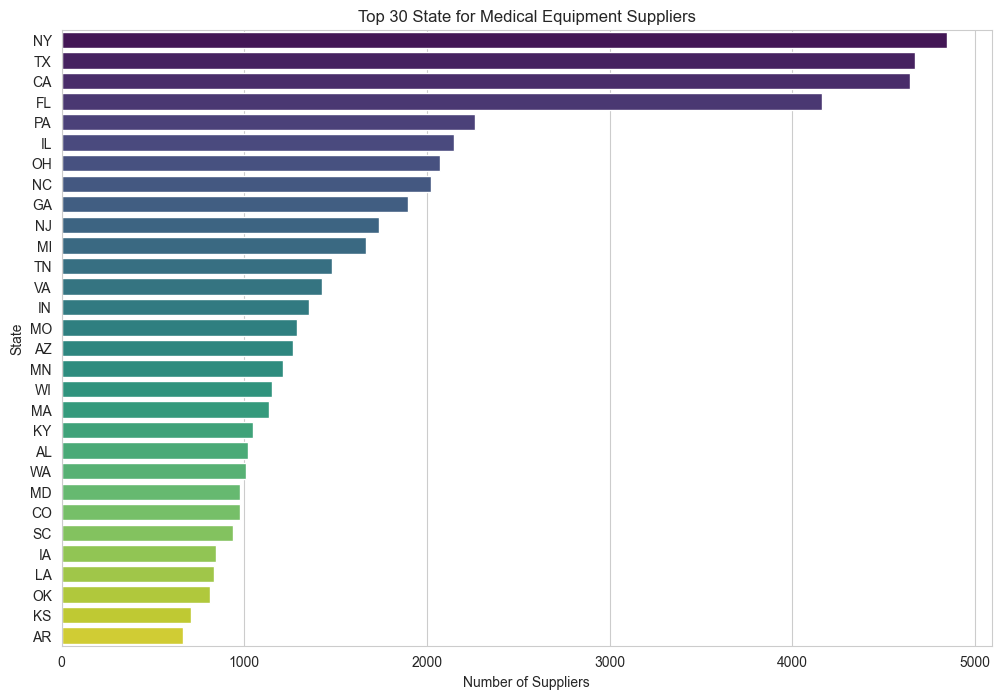

In [104]:
# Visualization of Question 1:Visualization for the first 30 states with the most suppliers
print("\n--- Visualizing the top 30 states with the most suppliers ---")
plt.figure(figsize=(12, 8))
sns.countplot(y='practicestate', data=df, order=df['practicestate'].value_counts().iloc[:30].index, palette='viridis')
plt.title('Top 30 State for Medical Equipment Suppliers')
plt.xlabel('Number of Suppliers')
plt.ylabel('State')
plt.show()

#### **Answer to Question 2: What is the proportion of suppliers who accept assignment?**
**Analysis:** We calculate the percentages for the boolean column `acceptsassignement`.
**Visualization:** A pie chart immediately illustrates the proportion between the two categories.
**Explanation of the Visualization:** The result is almost a 50/50 split: **48.4%** of suppliers accept assignment, while **51.6%** do not. This is a fundamental insight that indicates a systemic challenge in patient access to care.

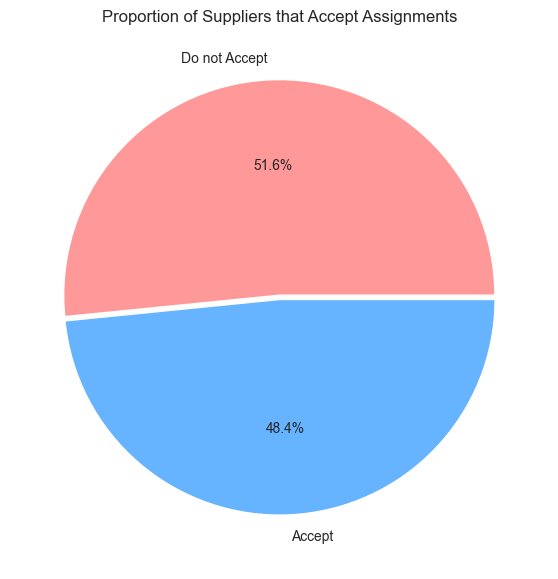

In [105]:
# Visualizzation of Question 2: Proportion of Suppliers that Accept Assignments
plt.figure(figsize=(7, 7))
df['acceptsassignement'].value_counts().plot.pie(
    autopct='%1.1f%%',
    labels=['Do not Accept', 'Accept'],
    colors=['#ff9999','#66b3ff'],
    explode=(0.02, 0)
)
plt.title("Proportion of Suppliers that Accept Assignments")
plt.ylabel('')
plt.show()

#### **Answer to Question 3: Is it possible to build a model to predict whether a supplier will accept assignment?**
**Analysis:** To answer this question, we evaluate the performance of the model we trained in Section 4. We use the test set, which contains data the model has never seen before.
**Model Results:**
*   **Accuracy:** The model correctly predicts the outcome approximately **74%** of the time.
*   **Precision and Recall:** The classification report shows that the model is reasonably balanced and does not excessively favor one class over the other.
**Explanation of the Results:** Yes, it is possible to build a predictive model with reasonable effectiveness. Although there is room for improvement, an accuracy of 74% demonstrates that there are patterns in the data that the model was able to learn. This model can already serve as a useful tool for preliminary estimates.

### 6. Visualize and Apply Results
Finally, we apply our model to a practical use case to demonstrate its value.
#### Hypothetical Scenario
What would happen if a new pharmacy opened in Pharr, Texas? We can use our model to predict it.
**Conclusion:**
The model predicts that the new pharmacy will most likely **not accept assignment**. This type of prediction, based on thousands of real data points, can provide valuable strategic insight for new businesses in the healthcare sector.
Fourth Snippet:

In [106]:
# Evaluation of the model's performance
print("\n--- Evaluating the model's performance ---")
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}\n")
print(classification_report(y_test, y_pred))


--- Evaluating the model's performance ---
Accuracy: 61.80%

              precision    recall  f1-score   support

       False       0.61      0.61      0.61      5723
        True       0.62      0.63      0.63      5943

    accuracy                           0.62     11666
   macro avg       0.62      0.62      0.62     11666
weighted avg       0.62      0.62      0.62     11666



#### **Practical Application: Prediction for a Hypothetical Scenario**
After validating the model, the final step is to demonstrate its practical value. We apply it to a realistic use case: what would happen if a new pharmacy opened today? We can use our model to make an informed prediction.
**Scenario:**
*   **Name:** "PharmaHealth" (hypothetical)
*   **Type:** Pharmacy
*   **Location:** Pharr, Texas (TX)
*   **Coordinates:** Latitude `26.19`, Longitude `-98.18`
We use a function to prepare this data in the correct format and feed it into our trained model.
**Final Conclusion:**
The model predicts that the new pharmacy will most likely **not accept assignment**. This type of insight, generated in seconds, could be invaluable for market research, strategic planning, or for the pharmacy itself as it decides on its management policies. It demonstrates how a well-structured data analysis can translate into practical decision-making tools.


In [107]:
def predict_new_scenario(model, X_template: pd.DataFrame):
    """Runs a prediction on a hypothetical scenario and prints the result.
    This function creates a single data point corresponding to the scenario,
    prepares it in the format required by the model (same columns, dtypes,
    and order), and finally runs and interprets the prediction.
    Args:
        model: The trained machine learning model.
        X_template (pd.DataFrame): A DataFrame of features (e.g., X_train) to use
                                   as a template for the structure.
    """
    print("\n--- Prediction of hypothetical scenario ---")
    
    # 1. Create a new DataFrame with the same structure as X_template
    # This ensures that the new data point has the same columns and dtypes.
    nuovo_fornitore_df = pd.DataFrame(columns=X_template.columns).astype(X_template.dtypes)
    nuovo_fornitore_df.loc[0] = [pd.NA] * len(X_template.columns)

    # 2. Populate the new DataFrame with the hypothetical scenario data
    # In this case, we are simulating a new pharmacy in Pharr, TX.
    nuovo_fornitore_df.loc[0, 'latitude'] = 26.19
    nuovo_fornitore_df.loc[0, 'longitude'] = -98.18
    nuovo_fornitore_df.loc[0, 'is_contracted_for_cba'] = False

    # Ensure that the new DataFrame has the same columns as the model expects
    if 'practicestate_TX' in nuovo_fornitore_df.columns:
        nuovo_fornitore_df.loc[0, 'practicestate_TX'] = 1
    if 'specialitieslist_Pharmacy' in nuovo_fornitore_df.columns:
        nuovo_fornitore_df.loc[0, 'specialitieslist_Pharmacy'] = 1
        
    # 3. Fill missing values and ensure correct dtypes
    # This step is crucial to ensure that the model can process the new data point.
    nuovo_fornitore_df = nuovo_fornitore_df.infer_objects(copy=False)
    nuovo_fornitore_df.fillna(0, inplace=True)
    
    # 4. Execute the prediction
    # The model expects the same structure as the training data.
    previsione = model.predict(nuovo_fornitore_df)
    probabilita = model.predict_proba(nuovo_fornitore_df)
    
    risultato = "Accept the assignation" if previsione[0] else "Does NOT accept the assignation"
    print(f"Forecast: The new pharmacy in Pharr, TX, will most likely '{risultato}'.")
    print(f"Estimated probabilities (False, True): {probabilita[0]}")


# Final call to the function to demonstrate the application of the model
print("\n--- Predicting a new scenario ---")
predict_new_scenario(model, X)


--- Predicting a new scenario ---

--- Prediction of hypothetical scenario ---
Forecast: The new pharmacy in Pharr, TX, will most likely 'Accept the assignation'.
Estimated probabilities (False, True): [0.45 0.55]
